# TP 2 : Expectation-Maximisation algorithm – Importance sampling

## Exercise 1: Discrete distributions

### Question 1 : 

**Inverse transform method**

Let's have : $s_k = \sum_{i = 1}^k p_i$


If $U \sim \mathcal{U}([0,1])$, then :
$$\mathbb{P} \left( U \in [s_{i-1}, s_i[ \right) = s_i - s_{i-1} = p_i = \mathbb{P}(X = x_i)$$

Finally, 
$$\boxed{\sum_{i = 1}^n x_i {1}_{[s_{i-1}, s_i[}(U) \sim X}$$

One way to generate the random variable X is to sample a uniform random variable U and if U is in $[s_{i-1}, s_i[$ X takes the value $x_i$.

### Question 2 :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
np.random.seed(2)

In [3]:
def discrete_cumulative(p):
    """
    Parameters
    ----------
    p : np.array 
        The probability distribution.
    
    Return
    ----------
    cumulative : np.array
        The cumulative function of a discrete probability distribution.
    """
    
    cumulative = np.zeros((len(p)))
    i = 0 
    
    for pi in p:
        cumulative[i] = cumulative[i-1] + pi
        i += 1
        
    return cumulative

def generateRV(X, cumulative, N = 1):
    """
    Parameters
    ----------
    X : np.array
        A set of distinct real numbers.
    cumulative : np.array 
        The cumulative function of the distribution.
    N : int
        Number of samples to be generated by the inverse transformation method.
        
    Return
    ----------
    sequence : np.array
        Sequence of i.i.d random variables having the same distribution as in the previous question.
    """
    
    U = np.random.uniform(size = N)
    sequence = np.zeros(N)
    
    i = 0 
    for u in U : 
        # find the index k of the first s_k s.t U < s_k
        index = np.where(u<=cumulative)[0][0]    
        # X_i = x_index
        sequence[i] = X[index]
        i += 1
        
    # np.random.choice could have been used as well    
    return sequence

### Question 3 :

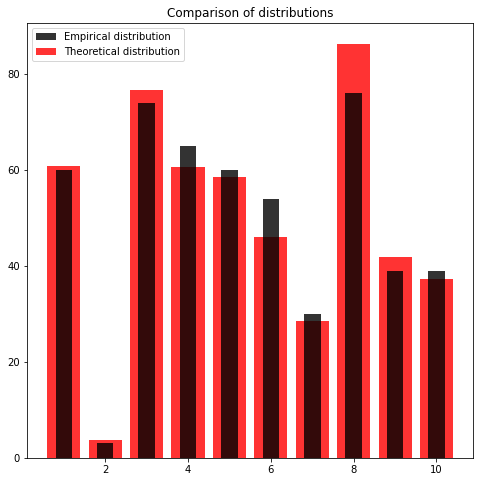

In [4]:
# Parameter initialization
n = 10
N = 500

# Set of values of the r.v
X = range(1, n+1)

# Probability distribution
p = np.random.rand(n)
p = p/sum(p)

# Sequence generation
cumulative = discrete_cumulative(p)
X = generateRV(X, cumulative, N)

# Histograms 
plt.figure(figsize = (8,8))
plt.title('Comparison of distributions')
plt.bar([1+i for i in range(n)], N*p, color='red', alpha=0.8, label='Theoretical distribution')
plt.hist(X, [0.5+i for i in range(n+1)], rwidth=0.4, color='black', alpha=0.8, label='Empirical distribution')
plt.legend()
plt.show()

## Exercise 2: Gaussian mixture model and the EM algorithm

### Question 1 : 

Let $(\alpha_1, ..., \alpha_m) \in \mathbb{R}_{+}^{m}$ such that $\sum_{i=1}^{m} \alpha_i = 1$ and the following hierarchical model : 

$$\forall i \in [\![1,n]\!] \quad \forall j \in [\![1,m]\!], \qquad\mathbb{P}_{\theta}(Z_i = j) = \alpha_j$$
and 
$$\forall i \in [\![1,n]\!] \quad \forall j \in [\![1,m]\!], \quad X_i \vert \theta , \{ Z_i = j \} \sim \mathcal{N}(\mu_j, \Sigma_j)$$

The parameters of the model are : $\boxed{\theta = \left( (\alpha_j, \mu_j, \Sigma_j) \right)_{1 \leq j \leq m}}$


Let $f_{\theta}$ be the probability density function of X. 

The likelihood of $\theta$ given the outcomes $(x_i)_{i \in [\![1,n]\!]}$ of the i.i.d n-sample $(X_i)_{i \in [\![1,n]\!]}$ is :
$$\mathcal{L}(x_1, . . . , x_n; \theta) = \prod_{i=1}^n f_{\theta}(x_i)$$.

By applying the law of total probability,
$f_{\theta}(x_i) = \sum_{k = 1}^m f_{\theta}(x_i \vert Z_i = k).\mathbb{P}(Z_i = k) = \sum_{k = 1}^m \phi(x_i, \mu_k, \Sigma_k).\alpha_k$ 

with $\phi(x_i, \mu_k, \Sigma_k) = \dfrac{1}{\sqrt{(2 \pi)^{d} | \Sigma_k |}} \exp \left( - \dfrac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) \right)$


$$\boxed{\mathcal{L}(x_1, . . . , x_n; \theta) = \prod_{i=1}^n \left( \sum_{k = 1}^m \phi(x_i, \mu_k, \Sigma_k).\alpha_k\right)}$$

### Question 2 :

Let's use that :

$$\text{if} \quad Y \sim \mathcal{N}(0,I) \quad \text{then} \quad L.Y + \mu \sim \mathcal{N}(\mu,L.L^T)$$

In [5]:
from scipy.stats import multivariate_normal

In [6]:
##### Parameter initialization #####
m = 3
n = 500
d = 2

alpha = np.random.rand(m)
alpha = alpha/sum(alpha)

mu = np.random.rand(m,d)*100

# Choleski decomposition
L = np.tril(np.random.rand(m,d,d)*10)
sigma = L@np.transpose(L, (0,2,1))
####################################


### Gaussian Mixture generation ####
X = np.zeros((n,d))
labels = np.zeros(n)

cumulative_alpha = discrete_cumulative(alpha)
Z = generateRV(range(0,m),cumulative_alpha, n)

normal = multivariate_normal.rvs(mean=None, cov=np.eye(d), size=n)

for i in range(n):
    X[i] = L[int(Z[i])]@normal[i] + mu[int(Z[i])]
    labels[i] = int(Z[i])
####################################

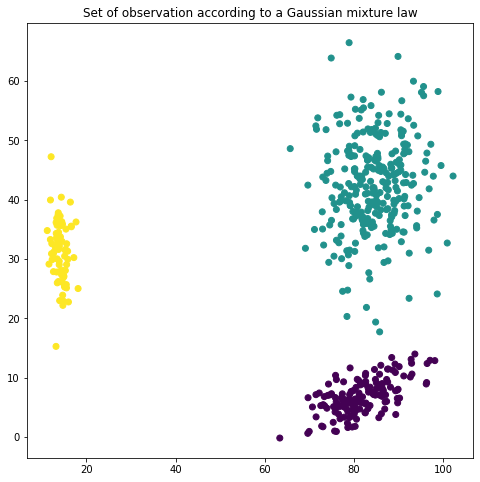

In [7]:
# Plot the generated mixture
plt.figure(figsize = (8,8))
plt.title('Set of observation according to a Gaussian mixture law')
plt.scatter(X[:,0],X[:,1], c = labels)
plt.show()

### Question 3 : 

The EM algorithm proceeds in two steps: 

(Etape E) We compute $Q(\theta \vert \theta_t) = \mathbb{E}_{f_{\theta_t}(Z \vert X_1^n)}\left[\log(q_{\theta}(X,Z)) \right] = \sum_{j = 1}^m \mathbb{E}_{f_{\theta_t}(Z_j \vert X_j)}\left[\log(q_{\theta}(X_j,Z_j)) \right]$ because the $(X_i)$ are i.i.d

(Etape M) We update : $\theta_{t+1} = argmax_{\theta \in \Theta} Q(\theta \vert \theta_t)$ 



First of all, we have : 

$$\theta = \left( (\alpha_j, \mu_j, \Sigma_j) \right)_{1 \leq j \leq m}$$

$$\log(q_{\theta}(X_j,Z_j)) = \log(q_{\theta}(X_j \vert Z_j)) + \log(q_{\theta}(Z_j))  = \sum_{k = 1}^m \log(q_{\theta}(X_j \vert Z_j = k)) + \log(q_{\theta}(Z_j = k)).1_{ \{Z_j = k \}}$$
$$\\ \qquad  = \sum_{k = 1}^m \left(- \dfrac{1}{2} (X_j - \mu_k)^T \Sigma_k^{-1} (X_j - \mu_k) - \dfrac{d}{2} \log(2\pi) - \dfrac{1}{2} \log(|\Sigma_k |) + \log(\alpha_k)\right).1_{ \{Z_j = k \}}$$

<br> 
It follows : 

$\mathbb{E}_{f_{\theta_t}(Z_j \vert X_j)}\left[\log(q_{\theta}(X_j,Z_j)) \right] =$

$\qquad  \qquad \sum_{k = 1}^m (- \dfrac{1}{2} (X_j - \mu_k)^T \Sigma_k^{-1} (X_j - \mu_k) - \dfrac{d}{2} \log(2\pi) - \dfrac{1}{2} \log(|\Sigma_k |) + \log(\alpha_k)).\mathbb{P}\left(Z_j = k \vert X_j, \theta_t \right)$

<br> 
Then 

$Q(\theta \vert \theta_t) = \sum_{j = 1}^n \sum_{k = 1}^m \left(- \dfrac{1}{2} (X_j - \mu_k)^T \Sigma_k^{-1} (X_j - \mu_k) - \dfrac{d}{2} \log(2\pi) - \dfrac{1}{2} \log(|\Sigma_k |) + \log(\alpha_k)\right).\mathbb{P}\left(Z_j = k \vert X_j, \theta_t \right)$

Maximizing with respect to $\theta = \left( (\alpha_j, \mu_j, \Sigma_j) \right)_{1 \leq j \leq m}$ is the same as maximizing with respect to $\alpha$ and then to $(\mu, \Sigma)$ because the problem is separable into these variables.

$\alpha^{t+1}$ is a solution of a maximization problem under constraint $\sum_{j = 1}^m \alpha_j  = 1$ 

From the course : 
$\boxed{\alpha_k^{t+1} = \frac{1}{n}\sum_{j=1}^n \mathbb{P}\left(Z_j = k \vert X_j, \theta_t \right)}$

Let's write $p_{jk}^t = \mathbb{P}\left(Z_j = k \vert X_j, \theta_t \right)$ for greater clarity.
Now, the challenge is to maximize Q with respect to  $(\mu, \Sigma)$ which is more complicated because the variables are not linearly separable.


**Hypothesis :** (*)

<br>

- Q is concave in $\mu$ and concave in $\Sigma$ but not jointly.

<br>

- Let us assume that maximizing with respect to $\mu$ and then maximizing w.r.t $\Sigma$ is equivalent to maximizing w.r.t $(\mu, \Sigma)$ jointly.

<br>

- All $\Sigma_k$ are invertible.

Q is concave in $\mu_k$. So I compute the gradient of Q with respect to it which must be zero:
$$\nabla_{\mu_k} Q(\mu_k^*) = - \sum_{j = 1}^n p_{jk}^t\Sigma_k^{-1} (\mu_k^*  - X_j) = 0 \Leftrightarrow \sum_{j = 1}^n p_{jk}^t (\mu_k^*  - X_j) = 0$$

This gives me : 
$$\boxed{\mu_k^* = \dfrac{1}{n \alpha_k} \sum_{j = 1}^n p_{jk}^t X_j}$$ 

I do the same for $\Sigma_k^{-1}$ :
$$\nabla_{\Sigma_k^{-1}} Q(\Sigma_k^{-1 *}) = \dfrac{1}{2} \sum_{j = 1}^n p_{jk}^t\left( \Sigma_k^* - (X_j - \mu_k) (X_j - \mu_k)^T \right) = 0 $$

This gives me
$$\boxed{\Sigma_k^* = \dfrac{1}{n \alpha_k} \sum_{j = 1}^n p_{jk}^t (X_j - \mu_k) (X_j - \mu_k)^T}$$




**Proof of the hypothesis**

<br>

- Q is clearly concave $\mu$ as a sum of concave functions.

<br>

- $\Sigma_k^{-1} \mapsto - \dfrac{1}{2} (X_j - \mu_k)^T \Sigma_k^{-1} (X_j - \mu_k)  + \dfrac{1}{2} \log(|\Sigma_k^{-1}|) = - \dfrac{1}{2} (X_j - \mu_k)^T \Sigma_k^{-1} (X_j - \mu_k)  - \dfrac{1}{2} \log(|\Sigma_k|)$ is concave too.


Suppose that the couple $(\mu^0, \Sigma^0)$ maximizes Q. 

Then,
$Q(\mu^*, \Sigma^*) \leq Q(\mu^0, \Sigma^0)$

Now, $\mu \mapsto \sum_{j = 1}^n \sum_{k = 1}^m \left(- \dfrac{1}{2} (X_j - \mu_k)^T \Sigma_k^{-1 \, 0} (X_j - \mu_k) - \dfrac{d}{2} \log(2\pi) - \dfrac{1}{2} \log(|\Sigma_k^0 |) + \log(\alpha_k)\right).\mathbb{P}\left(Z_j = k \vert X_j, \theta_t \right)$ admits a maximum in $\mu^*$ 

Therefore $\mu^0 = \mu^*$ and does not depend on $\Sigma^0$

Thus, $Q(\mu^*, \Sigma^*) \leq Q(\mu^0, \Sigma^0) = Q(\mu^*, \Sigma^0)$

Now, just notice that I have shown that
$$\Sigma \mapsto \sum_{j = 1}^n \sum_{k = 1}^m \left(- \dfrac{1}{2} (X_j - \mu_k^*)^T \Sigma_k^{-1} (X_j - \mu_k^*) - \dfrac{d}{2} \log(2\pi) - \dfrac{1}{2} \log(|\Sigma_k|) + \log(\alpha_k)\right).\mathbb{P}\left(Z_j = k \vert X_j, \theta_t \right)$$
admits a maximum in $\Sigma^*$

Finally $(\mu^*, \Sigma^*)$ is a maximizer for Q.

In [8]:
def EM(X, m, n_iter, plotLogLik = True, plotClusters = True):
    """
    EM Algorithm with a Gaussian Mixture Model
    
    Parameters
    ----------
    X : np.array [nxd]
        Data set of n observations.
    m : int
       The number of clusters of the Gaussian Mixture Model.
    n_iter : int
        Number iterations of the EM algortihm.
    plotLogLik : boolean
        Plot the log-likelihood if True.
    plotClusters : boolean
        Plot the p.d.f of the GMM estimated. 
    Return
    ----------
    (alpha, mu, sigma) : (np.array,np.array,np.array) [m,mxd,mxdxd]
        Return the estimated parameters of the GMM.
    logLikelihood : np.array [n_iter]
        The value of the Log-Likekihood at each iteration.
    """
    
    # Initialization
    n, d = X.shape
    logLikelihood = []

    # Mean of X
    meanX = X.mean(0)
    # Covariance of X
    covX = (X - meanX).T @ (X - meanX) / len(X)
    
    # Initial parameters
    alpha = np.ones(m) / m
    mu = np.zeros((m,d))
    sigma = np.zeros((m,d,d))
    for init in range(m):
        mu[init] = np.array(np.random.multivariate_normal(meanX, covX))
        sigma[init] = np.array([covX/ m**2])

    # Adding 1e-5.I to sigma to make it invertible 
    sigma = sigma + np.eye(d)*1e-5
    
    # Center X with respect to mu for the computation of sigma
    Xc = X.reshape(n, 1, d, 1) - mu.reshape(1, m, d, 1)
    
    for t in range(n_iter):
        
        ############################ E step ############################
        detSigma = np.linalg.det(sigma)
        invSigma = np.linalg.inv(sigma)
        cov = Xc.transpose((0, 1, 3, 2)) @ invSigma.reshape(1, m, d, d) @ Xc
        
        # Generative model
        p = np.exp(-0.5 * cov.reshape(n, m)) * alpha / ((detSigma * (2*np.pi)**d) ** 0.5)
        density_obs = p.sum(1)  
        p /= density_obs.reshape(n, 1)
    
        # LogLikelihood update
        logLikelihood.append(np.log(density_obs).sum())
        ################################################################
        
                
        ############################ M step ############################
        alpha = p.sum(0)/n
        mu = (p.reshape(n, m, 1) * X.reshape(n, 1, d)).sum(0) / (n*alpha.reshape(m, 1))
        Xc = X.reshape(n, 1, d, 1) - mu.reshape(1, m, d, 1)
        sigma = (p.reshape(n, m, 1, 1) * (Xc @ Xc.transpose((0, 1, 3, 2)))).sum(0) / (n*alpha.reshape(m, 1 ,1))
        sigma = sigma + np.eye(d)*1e-5
        ################################################################
        
    if plotLogLik : 
    
        plt.figure(figsize = (8,8))
        plt.title('Log-likelihood')
        plt.plot(logLikelihood)
        plt.xlabel('Iteration n°')
        plt.show()
        
    if plotClusters : 
        
        # Window parametrization
        xmin,xmax = X[:,0].min()-5,X[:,0].max()+5
        ymin,ymax = X[:,1].min()-5,X[:,1].max()+5
        x=np.linspace(xmin,xmax,2000)
        y=np.linspace(ymin,ymax,2000)
        X_grid, Y_grid = np.meshgrid(x, y)
        
        # Gaussians pdf
        Z = np.zeros((2000,2000))
        for i in range(2000):
            for j in range(m):
                Z[i] +=  alpha[j]*multivariate_normal.pdf(x=np.array([X_grid[i],Y_grid[i]]).T,
                                                          mean=mu[j], cov=sigma[j])
        fig, ax = plt.subplots()
        ax.scatter(X[:,0],X[:,1])
        for j in range(m) :
            ax.scatter(mu[j,0],mu[j,1],color='r')
        CS = plt.contour(X_grid, Y_grid, Z)
        plt.show()
        
    return alpha, mu, sigma, logLikelihood

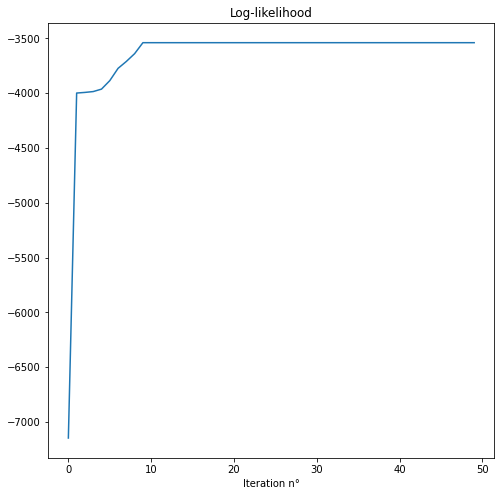

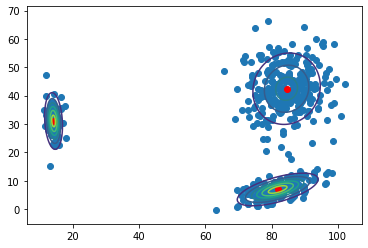

In [9]:
##### Parameter initialization #####
n_iter = 50
####################################

alpha_est, mu_est, sigma_est, logLikelihood = EM(X, m, n_iter)

### Question 4 : 

The EM is deterministic and depends greatly on the initializations.

In [10]:
# rearrange parameters and estimates for comparison

sortedList = np.argsort(alpha)
sortedList_est = np.argsort(alpha_est)

alpha = alpha[sortedList]
alpha_est = alpha_est[sortedList_est]

mu = mu[sortedList]
mu_est = mu_est[sortedList_est]

sigma = sigma[sortedList]
sigma_est = sigma_est[sortedList_est]

In [11]:
def relative_error(true, estimate):
    """ Return the relative L2-error (in %) between the estimate and the true value. """
    return round(np.linalg.norm(true - estimate)/np.linalg.norm(true) * 100,2)

In [12]:
print( "The relative error of estimated alpha is : ", relative_error(alpha, alpha_est),"%")
print( "The relative error of estimated mu is : ", relative_error(mu, mu_est),"%")
print( "The relative error of estimated sigma is : ", relative_error(sigma, sigma_est),"%")

The relative error of estimated alpha is :  3.72 %
The relative error of estimated mu is :  0.47 %
The relative error of estimated sigma is :  14.58 %


#### Comments 
Graphically, the EM algorithm works well and moreover it is clear that the estimates are very close (here, in L2) to the initial parameters.

### Question 5 : 

In [13]:
import pandas as pd

In [14]:
data = pd.read_csv('WPP2019_Period_Indicators_Medium.csv')
data = data[['MidPeriod','CBR','CDR']]

# Consider only the year 2018
data = data.iloc[np.where(data['MidPeriod'] == 2018)[0]]

# Keep only useful data
data = data[data['CBR'].notna()]

# Conversion to array
data = np.array(data[['CBR','CDR']])

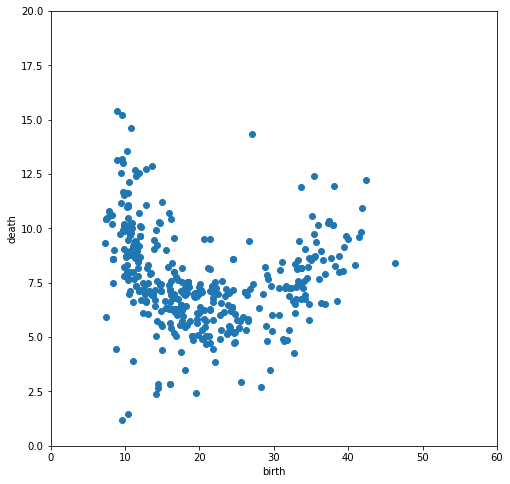

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(data[:,0],data[:,1])
plt.xlabel('birth')
plt.ylabel('death')
ax = plt.gca()
ax.set(xlim=(0, 60), ylim=(0, 20))
plt.show()

I expect that the data can be grouped by clusters according to the development of the countries. In reality, the ratio of births to deaths varies greatly between a developing and an already developed country. The Gaussian mixture model here can be adapted.

### Question 6 : 

**Computation of df**

For each Gaussian you have:

<br>

1. A Symmetric full DxD covariance matrix giving $\frac{(D*D - D)}{2}+ D$ parameters $\frac{(D*D - D)}{2}$ is the number of off-diagonal elements and D is the number of diagonal elements)

<br>

2. A D dimensional mean vector giving D parameters

<br>

3. A mixing weight giving another parameter

This results in $Df_{gaussian} = \frac{(D*D - D)}{2} + 2D + 1$ for each gaussian.

Given you have m components, you have $Df = (m*Df_{gaussian})-1$ parameters because the mixing weights must sum to 1 and you deduce the last one thanks to the (m-1) previous weights.

In [16]:
def df(m):
    """ Return the number of degrees of freedom of the mixture model with m clusters."""
    return m*((d*d - d)/2 + 2*d + 1) - 1

def BIC(X, n_iter, m_max):
    """ Find the minimizer of the BIC"""
    n = len(X)
    m_max = min(n, m_max)
    minimum_score, m_opt = np.Inf, 0
    for m in range(1, m_max+1):
        alpha, mu, sigma, logLikelihood = EM(X, m, n_iter, plotLogLik = False, plotClusters = False)
        LogLik = logLikelihood[-1]
        score = - LogLik + df(m)*np.log(n)/2
        if score < minimum_score:
            minimum_score, m_opt = score, m
    return m_opt

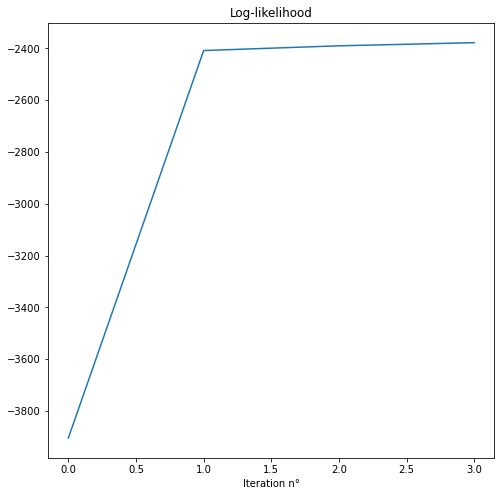

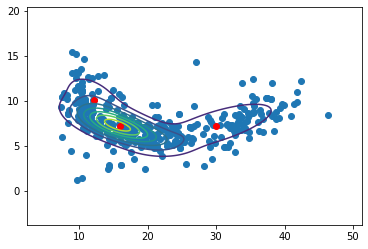

The optimal number of clusters is :  3


In [17]:
m_opt = BIC(data, n_iter = 100, m_max = 10)
alpha, mu, sigma, logLikelihood = EM(data, m_opt, n_iter = 4)
print("The optimal number of clusters is : ", m_opt)

Here, the Gaussian mixture model seems to work well because it manages to approximate the data representation. Moreover, I find thanks to the BIC criterion that the number of optimal clusters is 3, which can correspond to the three types of development of a country i.e. underdeveloped, in development and developed

## Exercise 3 : Importance sampling

### Question 1 :

In [18]:
from scipy.stats import norm

In [19]:
def f(x):
    return np.where(x>0, 2.*np.sin(x*np.pi/1.5), 0)

def p(x):
    """ density p without normalizatioN """
    x = np.where(x>0, x, 0)
    return np.where(x>0, x**(0.65)*np.exp(-x**2/2), 0)

def q(x,mu = 0.8,sigma = np.sqrt(1.5)):
    """ density q renormalized """
    return (2/np.sqrt(2*np.pi*sigma**2))*np.exp(-(mu-x)**2/(2*sigma**2))

def q_sampling(N,mu = 0.8, sigma = np.sqrt(1.5)):
    """ sample r.v with respect to the density q """
    sequence = np.zeros(N)
    
    i = 0 
    while(i<N) : 
        
        # Inversion transform method
        u = np.random.uniform()
        sequence[i] = norm.ppf(u) * sigma + mu
        
        # Keep only non-negative sample
        if (sequence[i]>=0):
            i+=1
            
    return sequence

def importance_sampling(N,mu = 0.8 ,sigma2 = 1.5):
    """
    Parameters
    ----------
    N : int 
        The number of q-sampling to consider.
    mu : float 
        The mean of the law with density q
    sigma : float
        The standard deviation of the law with density q
    
    Return
    ----------
    estimate : float
            The estimation by importance sampling of the expectation of f under the density p.   
    weights : np.array [Nx1]
            The importance weights.
    """
    
    # q-sampling
    X = q_sampling(N, mu, sigma2)
    
    # importance weights
    weights = p(X)/ q(X,mu,sigma2)
    
    # importance weights normalized
    w_normalized = weights / ((weights.sum())/N)
    estimate = (w_normalized*f(X)).sum()/N
    
    return estimate, weights

### Question 2 :

In [20]:
from scipy import integrate as intg

from scipy.integrate import quad
result = quad(lambda x: f(x)*p(x), 0, np.Inf)
print("The expected result is :", result[0])

The expected result is : 0.7752953044208203


#####################
N=10 and mu=0.8


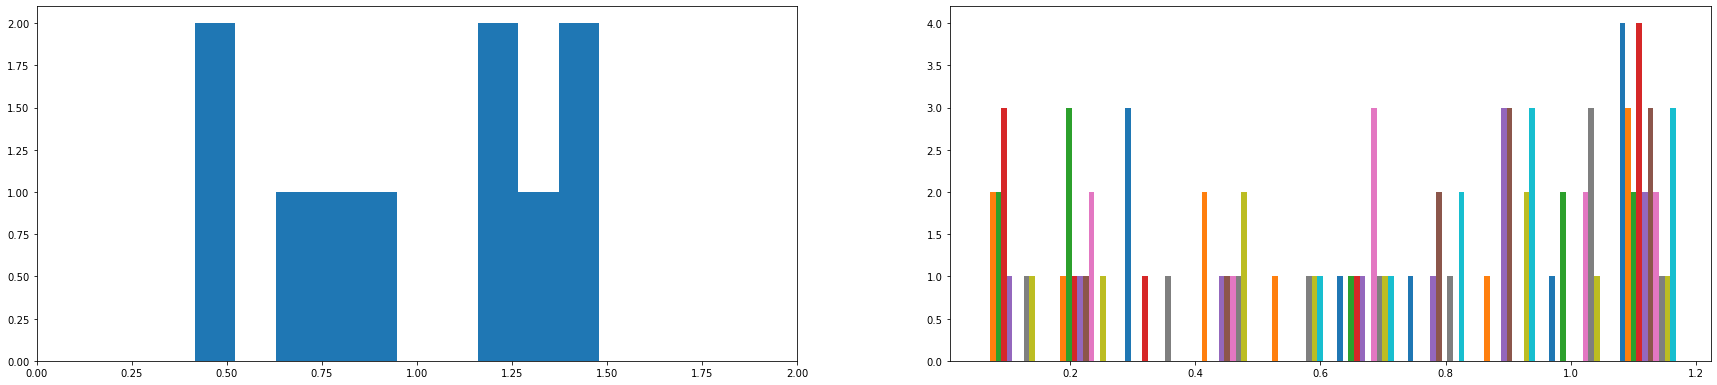

#####################
N=100 and mu=0.8


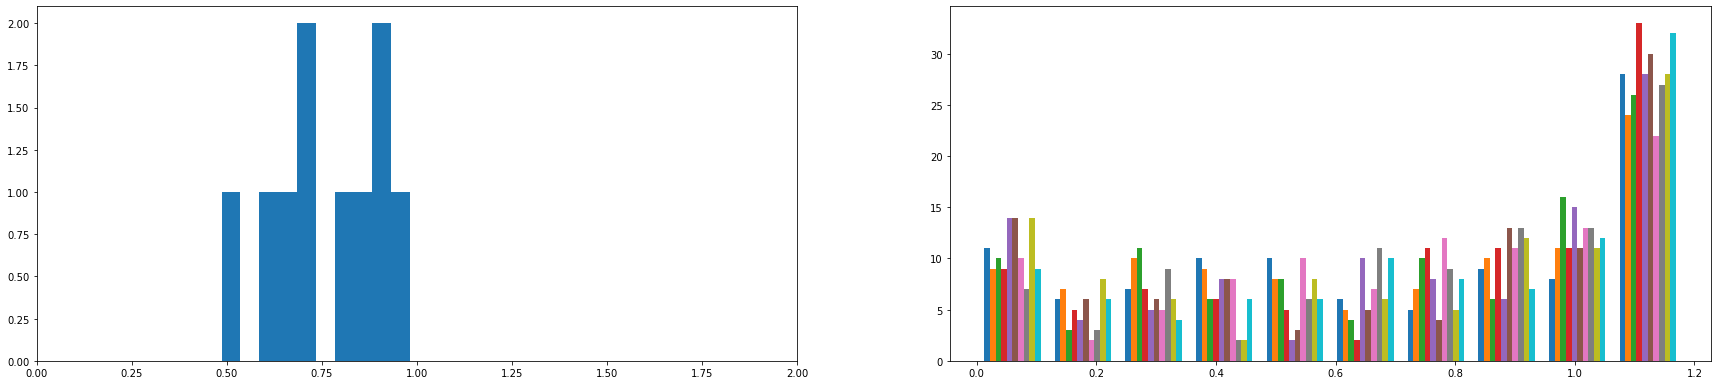

#####################
N=1000 and mu=0.8


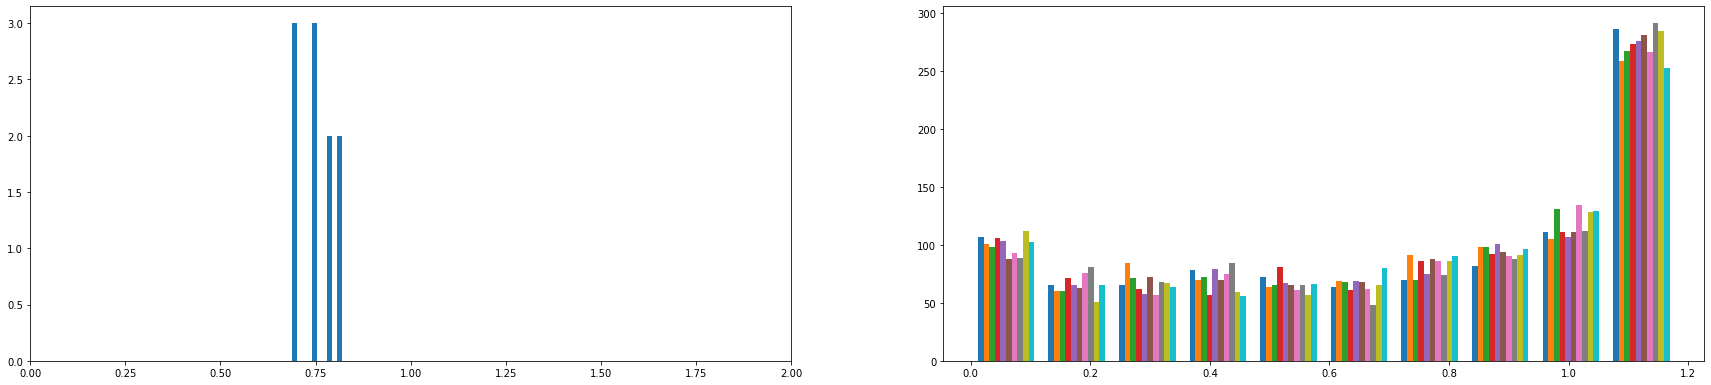

#####################
N=10000 and mu=0.8


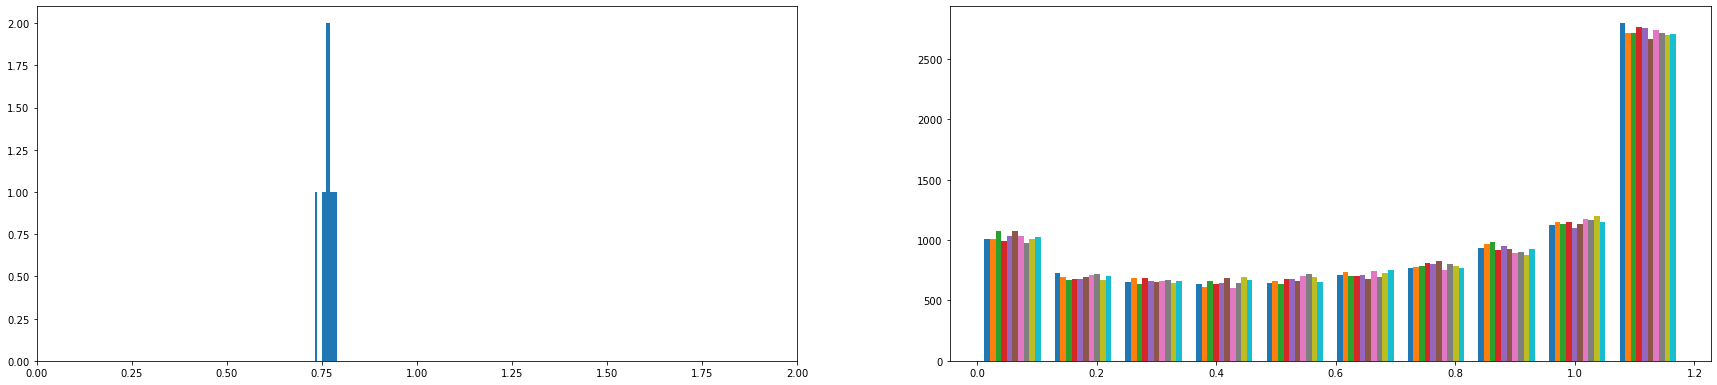

In [21]:
mu = 0.8
Ns = [10,100,10**3, 10**4]

num = 1
for N in Ns : 
    histogram_IP = []
    histogram_Ws = []
    for i in range(10):
        histogram_IP.append(importance_sampling(N, mu = mu)[0])
        histogram_Ws.append(importance_sampling(N, mu = mu)[1])
       
    print('#####################')
    print('N='+str(N) + ' and mu='+str(mu))
    plt.figure(figsize=(30,30))
    plt.subplot(4, 2, num)
    plt.hist(histogram_IP)
    plt.xlim(0,2)
    
    num+=1
    
    plt.subplot(4, 2, num)
    plt.hist(histogram_Ws)
    #plt.xlim(0,0.5)
    
    num+=1
    plt.show() 

### Comments
One can see that as N increases, the importance sampling algorithm converges to the expected value and the importance weights also converge.

### Question 3:

#####################
N=10 and mu=6


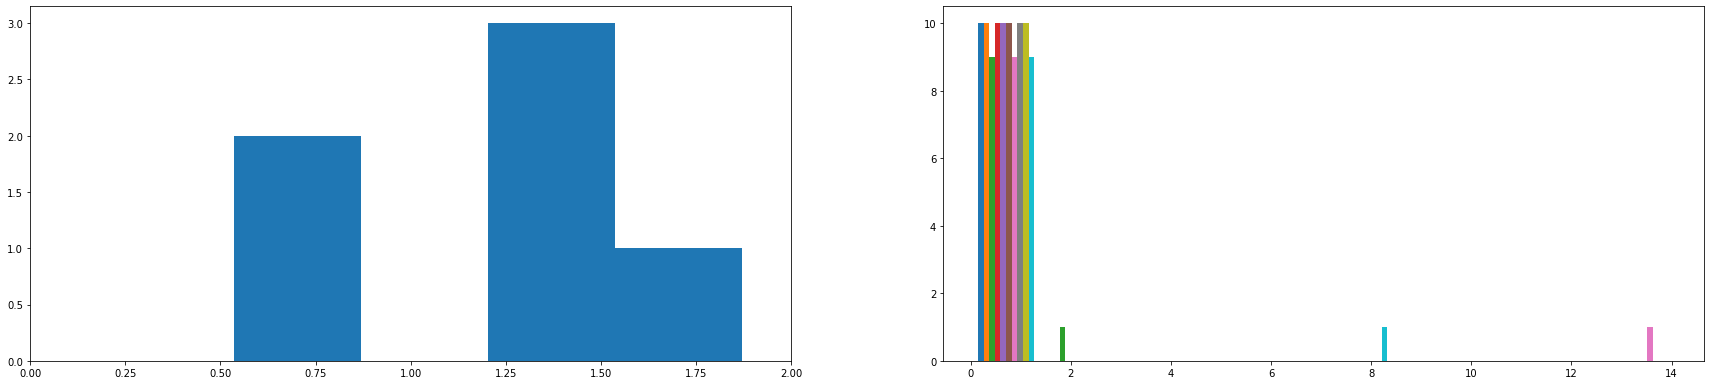

#####################
N=100 and mu=6


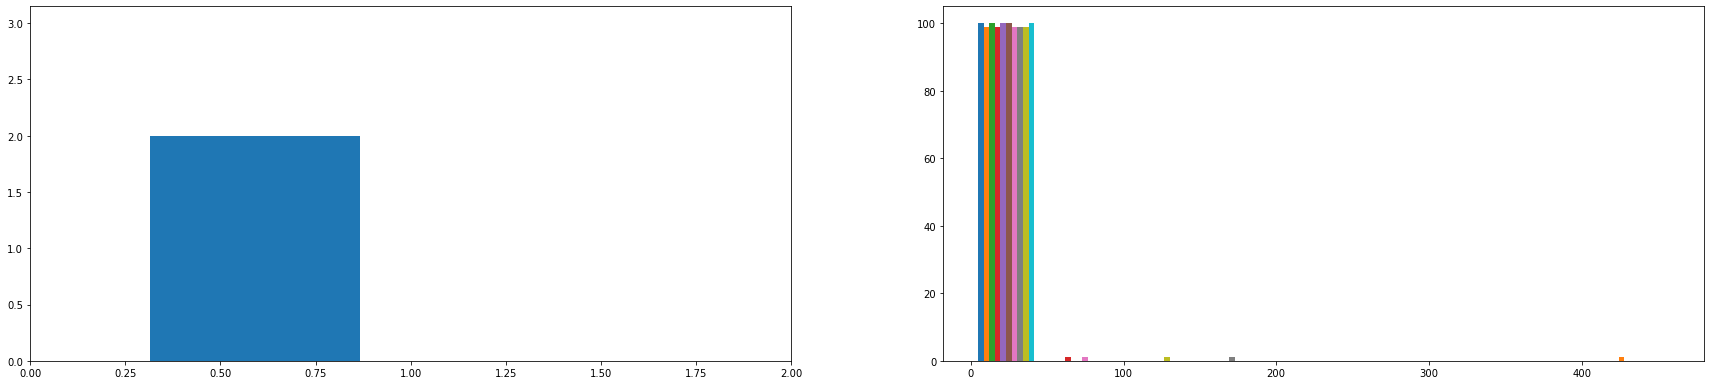

#####################
N=1000 and mu=6


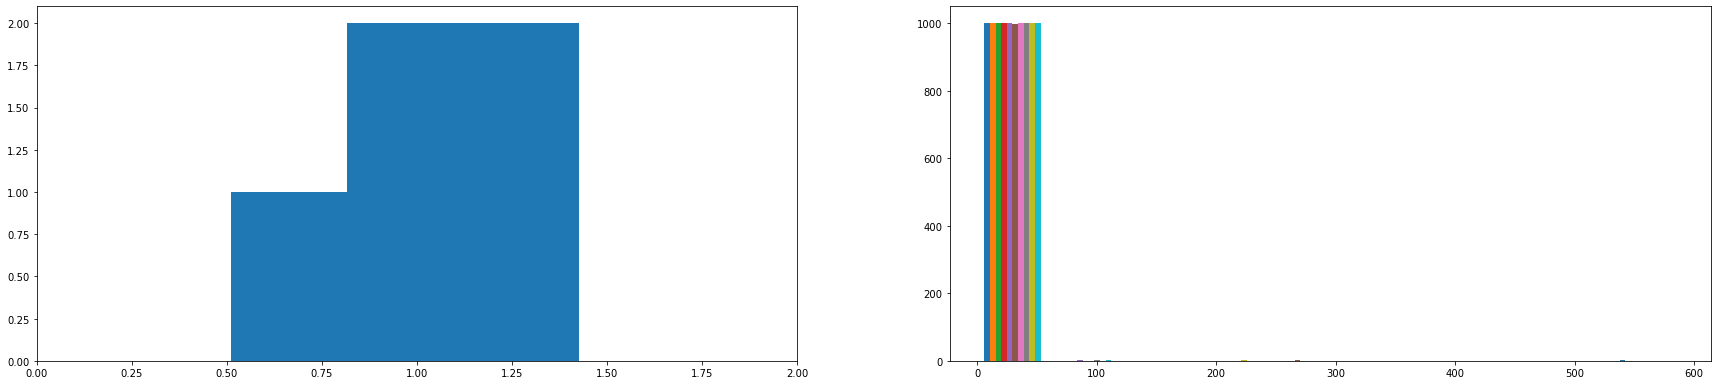

#####################
N=10000 and mu=6


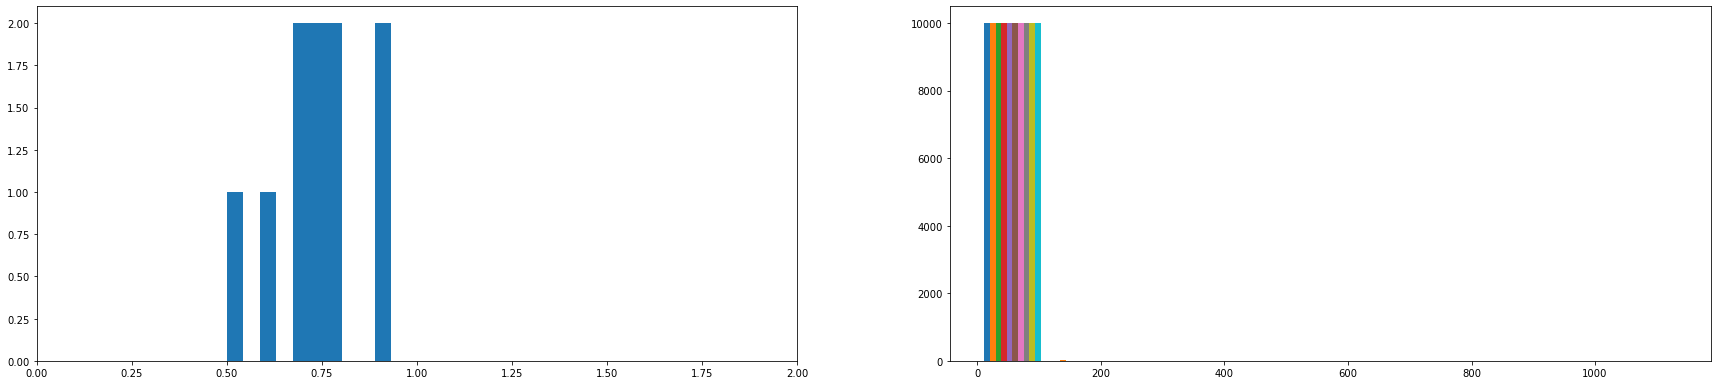

In [22]:
mu = 6
Ns = [10,100,10**3, 10**4]

num = 1
for N in Ns : 
    histogram_IP = []
    histogram_Ws = []
    for i in range(10):
        histogram_IP.append(importance_sampling(N, mu = mu)[0])
        histogram_Ws.append(importance_sampling(N, mu = mu)[1])
       
    print('#####################')
    print('N='+str(N) + ' and mu='+str(mu))
    plt.figure(figsize=(30,30))
    plt.subplot(4, 2, num)
    plt.hist(histogram_IP)
    plt.xlim(0,2)
    
    num+=1
    
    plt.subplot(4, 2, num)
    plt.hist(histogram_Ws)
    
    num+=1
    plt.show() 

### Comments

In this case, convergence appears to be occurring too, albeit at a slower rate and with a larger number of samples required. The importance weights have not yet converged. The reason why is because the centers of mass for each distribution are far apart. The values of the importance weights vary then from close to 0 to very large which leads to an oscillatory convergence.

### Question 4 : 

We want to maximize :
$$Q(\theta \vert \theta_0) = \sum_{i=1}^{n} \tilde{w_i}^{(0)} \log \left(\sum_{j=1}^{M} \alpha_j \phi(X_i^{(0)};\theta_j)\right)$$


with respect to $\alpha$, $\mu$ and $\Sigma$.


$$Q(\theta \vert \theta_t) = \sum_{i=1}^{n} \tilde{w_i}^{(0)} \log \left(f_{\theta}({X_i}^{(0)})\right) = \sum_{i=1}^{n} \tilde{w_i}^{(0)} \mathbb{E}_{f_{\theta_0}(Z_i \vert {X_i}^{(0)})}\left[\log \left(q_{\theta}(X_i, Z_i)\right)) \right]$$


with : 
$$\log(q_{\theta}(X_j,Z_j)) = \log(q_{\theta}(X_j \vert Z_j)) + \log(q_{\theta}(Z_j))  = \sum_{k = 1}^m \log(q_{\theta}(X_j \vert Z_j = k)) + \log(q_{\theta}(Z_j = k)).1_{ \{Z_j = k \}}$$
$$\\ \qquad  = \sum_{k = 1}^m \left(- \dfrac{1}{2} (X_j - \mu_k)^T \Sigma_k^{-1} (X_j - \mu_k) - \dfrac{d}{2} \log(2\pi) - \dfrac{1}{2} \log(|\Sigma_k |) + \log(\alpha_k)\right).1_{ \{Z_j = k \}}$$

<br> 

Then, it is the same reasoning as in question 2.3 but replacing $p_{jk}$ by $\tilde{w_j}^{(0)}.p_{jk}$

Finally, 

$$\boxed{\alpha_k^{1} = \frac{1}{n}\sum_{j=1}^n \tilde{w_j}^{(0)}.p_{jk}^0}$$

$$\boxed{\mu_k^1 = \dfrac{1}{n \alpha_k} \sum_{j = 1}^n \tilde{w_j}^{(0)}.p_{jk}^0 X_j}$$ 

$$\boxed{\Sigma_k^1 = \dfrac{1}{n \alpha_k} \sum_{j = 1}^n \tilde{w_j}^{(0)}.p_{jk}^0 (X_j - \mu_k) (X_j - \mu_k)^T}$$


### Question 5 : 

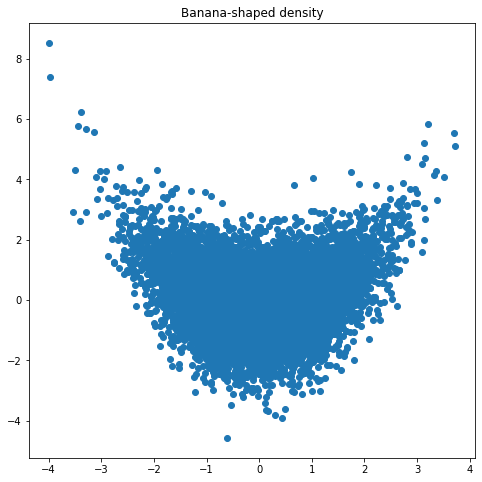

In [23]:
def banana(size, d, sigma1, b):
    """ Return the simulation of a banana-shaped density """
    # Initialization 
    mu = np.zeros(d)
    sigma = np.ones(d)
    sigma[0] = sigma1
    sigma=sigma*np.eye(d)
    
    
    banana_shaped = np.random.multivariate_normal(mu,cov=sigma, size=size)
    banana_shaped[:,1] = banana_shaped[:,1]+b*(banana_shaped[:,0]**2-sigma1**2)
    return banana_shaped

banana = banana(10000, d = 5, sigma1 = 1, b = 0.4)

plt.figure(figsize = (8,8))
plt.title('Banana-shaped density')
plt.scatter(banana[:,0],banana[:,1])
plt.show()

In [24]:
from copy import deepcopy
import copy

In [25]:
def Mixture_simulation(N, alpha, sigma, mu, d):
    """ Return the simulation of a Gaussian Mixture Model"""
    m = len(alpha)
    cumulative = discrete_cumulative(alpha)
    y = generateRV(range(0,m), cumulative, N)        
    simulation = np.zeros((N,d))
    num=0       
    label=np.array([])
    for i in range(0,m):
        n_i=np.sum(y==i)
        simulation[num:(num+n_i),:]=np.random.multivariate_normal(mu[i],sigma[i], n_i)
        num = num+n_i
        label=np.concatenate((label,np.repeat(i,n_i)))
        
    labels=[i for i in label]
    
    return simulation, labels

def Adaptative_Importance_Sampling(m, N = 10000, sigma1 = 1, d = 5, b = 0.4, tol=1e-3, max_iter=10):
    """
    Adaptative Importance sampling algorithm.
    
    Parameters
    ----------
    m : int
       The number of clusters of the Gaussian Mixture Model.
    N : int 
        The number of sampling to consider.
    mu : float 
        The mean of the law with density q
    sigma1 : float
        The twisting standard deviation
    d : int
        Dimension of the Gaussian function
    b : float
        Banana scale
    tol : float 
        The precision of the algorithm
    max_iter : int
        The maximum number of iterations.
    
    Return
    ----------
    (alpha, mu, sigma) : (np.array,np.array,np.array) [m,mxd,mxdxd]
        Return the estimated parameters of the banana-shaped density.
    logLikelihood : np.array [n_iter]
        The value of the Log-Likekihood at each iteration.
    """
    
    # Initialization 
    sigma = m*[np.eye(d)]
    mu = [np.random.uniform(low = 0.5, size=d) for _ in range(m)]
    alpha=np.ones(m)/m
    n_iter=0
    
    # Simulations 
    X, _ = Mixture_simulation(N, alpha, sigma, mu, d)
    
    while(max_iter>n_iter):
        
        counter = 0
        
        ################################################################
        ###################### Important sampling ######################
        ################################################################
        
        # Banana sampling
        ban_mu = np.zeros(d)
        ban_sigma = np.ones(d)
        ban_sigma[0] = sigma1
        ban_sigma= ban_sigma*np.eye(d)
        data_copy = deepcopy(X)
        data_copy[:,1]=data_copy[:,1]+b*(data_copy[:,0]**2-sigma1**2)
        banana_density = multivariate_normal.pdf(data_copy, mean = ban_mu,cov=ban_sigma)
        
        # Mixutre sampling        
        mixture_density = np.zeros((N,m))
        for j in range(m):
            mixture_density[:,j] = alpha[j]*multivariate_normal.pdf(X, mu[j],cov=sigma[j])
        mixture_density = mixture_density.sum(1)
    
        # Importance weights
        w=banana_density/mixture_density
        w_normalized = w/(w.sum()/N)
        
        ################################################################
        ################################################################
        ################################################################
        
        # Log-Likelihood Initialization
        logLikelihood=[-np.Inf]
        
        while True : 
            ################################################################
            ######################### EM Algorithm #########################
            ################################################################
        
            
            ############################ E step ############################
            detSigma = np.linalg.det(sigma)
            invSigma = np.linalg.inv(sigma)
            mu = np.array(mu)+1e-10
            Xc = X.reshape(N, 1, d, 1) - mu.reshape(1, m, d, 1)

            cov = Xc.transpose((0, 1, 3, 2)) @ invSigma.reshape(1, m, d, d) @ Xc

            # Generative model
            p = np.exp(-0.5 * cov.reshape(N, m)) * alpha / ((detSigma * (2*np.pi)**d) ** 0.5)
            density_obs = p.sum(1)  
            p /= density_obs.reshape(N, 1)  
            ################################################################
            
            ############################ M step ############################
            newp = w_normalized.reshape(N,1)*(p.reshape(N,m))       
            alpha = newp.sum(0)/N
            mu = (newp.reshape(N, m, 1) * X.reshape(N, 1, d)).sum(0) / (newp.sum(0).reshape(m,1))
            Xc = X.reshape(N, 1, d, 1) - mu.reshape(1, m, d, 1)
            sigma = (newp.reshape(N, m, 1, 1) * (Xc @ Xc.transpose((0, 1, 3, 2)))).sum(0) / (newp.sum(0).reshape(m,1,1))
            sigma = sigma + np.eye(d)*1e-5
            ################################################################
            
            ################################################################
            ################################################################
            ################################################################
            
            
            # Log-Likelihood update
            logLikelihood.append(np.log(density_obs).sum())
            
            # Stopping Criterion
            if (logLikelihood[-1] - logLikelihood[-2]<tol) or (counter > max_iter):
                break
            
            counter+=1
           
        X, _ = Mixture_simulation(N, alpha, sigma, mu,d)
        n_iter+=1
        
    X, labels = Mixture_simulation(N, alpha, sigma, mu,d)
    plt.scatter(X[:,0],-X[:,1],c=labels) 
    return alpha, mu, sigma, logLikelihood

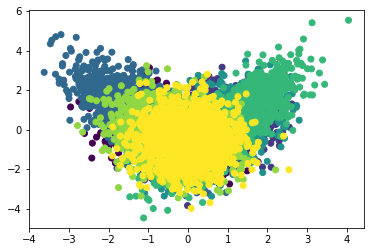

In [26]:
m= 7
max_iter=8
alpha,mu,sigma, loglik=Adaptative_Importance_Sampling(m, max_iter=max_iter)

In [27]:
def BIC_banana(X, n_iter, m_max):
    """ Find the minimizer of the BIC"""
    n = len(X)
    m_max = min(n, m_max)
    minimum_score, m_opt = np.Inf, 0
    
    for m in range(1, m_max+1):
        
        alpha, mu, sigma, logLikelihood = Adaptative_Importance_Sampling(m, max_iter=n_iter)
        LogLik = logLikelihood[-1]
        score = - LogLik + df(m)*np.log(n)/2
        
        if score < minimum_score:
            print("################# \n m :",m)
            minimum_score, m_opt = score, m   
            plt.show()
    return m_opt

################# 
 m : 1


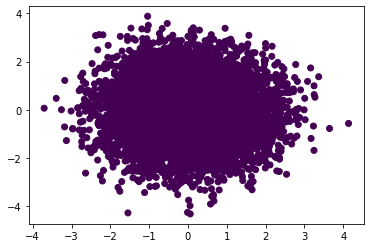

################# 
 m : 2


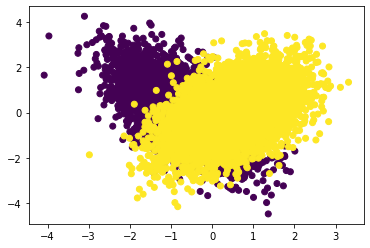

################# 
 m : 3


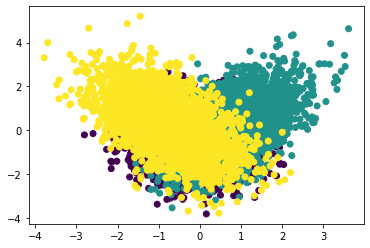

################# 
 m : 6


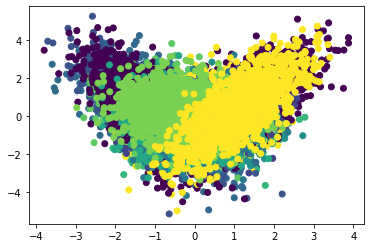

The optimal number of clusters is :  6


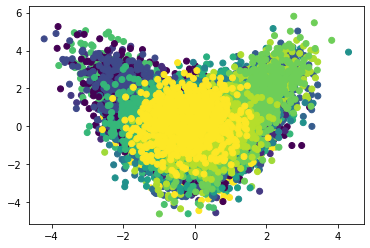

In [28]:
m_opt = BIC_banana(banana, 10, 10)
print("The optimal number of clusters is : ", m_opt)

This number can be interpreted as d-1 clusters for the d-1 invariant Gaussian functions and 2 for the Gaussian function twisted. Then, the optimal number of clusters is d+1 = 6.